In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split

import os
import importlib
from dotenv import load_dotenv
load_dotenv()

from tqdm import tqdm
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [7]:
misconceptions = pd.read_csv('../kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv', index_col='MisconceptionId')
train = pd.read_csv('../kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv')
train_melted = pd.read_csv('../kaggle/input/eedi-mining-misconceptions-in-mathematics/train_melted.csv')
test = pd.read_csv('../kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv')

# utils

In [94]:
client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))

def get_completion(prompt, max_tokens=50, model='gpt-4o-mini'):
    if model == 'o1-mini':
        completion = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": f"{prompt}"
                }
            ],
            max_completion_tokens=max_tokens,
            temperature=1
        )
    else: 
        completion = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": f"{prompt}"
                }
            ],
            max_tokens=max_tokens,
            temperature=0.2
        )
    return completion.choices[0].message.content

In [9]:
def clean_string(s: str) -> str:
    """
    Cleans string by converting to lowercase, striping whitespace, and removing periods and quotation marks.

    Args:
        s: The string to clean

    Returns:
        str: The cleaned string
    """

    trans = str.maketrans('', '', '."') 
    return s.strip().lower().translate(trans)


In [61]:
misconception_list = list(misconceptions['MisconceptionName'])

model = SentenceTransformer('all-mpnet-base-v2')
misconception_embeddings = model.encode(misconception_list, convert_to_tensor=True).cpu().numpy()

In [62]:
def match_misconception(response: str, subject: str, top_k: int = 3) -> list:
    """
    Matches response to the top k misconceptions from the misconception list using word embeddings.
    Returns a list of the top k matched misconceptions with their similarity scores.

    Args:
        response: The text to match against misconceptions
        subject: The subject area for context
        top_k: The number of top misconceptions to return

    Returns:
        list: A list of tuples containing the matched misconception and its similarity score
    """
    # Combine response with subject for context
    contextual_response = f"{response} (Subject: {subject})"
    
    # Compute embedding for the response and move to CPU, then convert to NumPy
    response_embedding = model.encode([contextual_response], convert_to_tensor=True).cpu().numpy()
    
    # Calculate cosine similarities between the response and all misconceptions
    similarities = cosine_similarity(response_embedding, misconception_embeddings)[0]
    
    # Get indices of top k similarities
    top_indices = similarities.argsort()[-top_k:][::-1]
    top_scores = similarities[top_indices]
    
    # Collect top k matches with their similarity scores
    top_matches = []
    for idx, score in zip(top_indices, top_scores):
        top_matches.append((misconception_list[idx], score))
    
    return top_matches

In [11]:
misconception_list = list(misconceptions['MisconceptionName'])
misconception_list

['Does not know that angles in a triangle sum to 180 degrees',
 'Uses dividing fractions method for multiplying fractions',
 'Believes there are 100 degrees in a full turn',
 'Thinks a quadratic without a non variable term, can not be factorised',
 'Believes addition of terms and powers of terms are equivalent e.g. a + c = a^c',
 'When measuring a reflex angle, gives the acute or obtuse angle that sums to 360 instead',
 'Can identify the multiplier used to form an equivalent fraction but does not apply to the numerator',
 'Believes gradient = change in y',
 'Student thinks that any two angles along a straight line are equal',
 'Thinks there are 180 degrees in a full turn',
 'Believes duration can be read from a timetable, rather than calculating from start and end times',
 'When reading value from graph, reads from the wrong axes.',
 'Thinks that the side view does not include the furthest rows back',
 'Does not subtract from the hours, when having to borrow for a time calculation',
 '

# Data

In [53]:
# Create subset of train where misconception is in misconceptions
train_subset = train_melted[train_melted['MisconceptionName'].notna()]
train_subset = train_subset.sample(n=100, random_state=12)
train_subset.head(5)

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerText,AnswerOption,MisconceptionId,MisconceptionName
1869,643,277,Carry out division problems involving negative non-integers,212,Multiplying and Dividing Negative Numbers,A,\( \frac{(-3) \times(-2)}{(-0.2)}= \),\( -3 \),B,1619.0,"When dividing a decimal by a whole number, ignores decimal point and just divides the digits"
2996,267,559,Calculate questions involving the power law of indices with positive integer powers,247,Laws of Indices,A,\( \left(5^{4}\right)^{3}= \),\( 125^{12} \),C,2473.0,Has cubed the base number and the power
1057,1422,1596,"Calculate coordinates of points on the graph of y = ax, where x is a positive non-integer",160,Graphs of Exponentials and Other Powers of x,C,This is a part of the table of values for the equation \( \boldsymbol{y}=\mathbf{8}^{\boldsymbol{x}} \) \begin{tabular}{|l|c|}\n\hline\( x \) & \( \frac{1}{3} \) \\\n\hline\( y \) & \(\color{gold}\bigstar\) \\\n\hline\n\end{tabular} What should replace the star?,\( \frac{8}{3} \),A,1072.0,Multiplies by the index
2199,1074,3134,Identify factors of algebraic expressions,52,Factorising into a Single Bracket,D,Which of the following is a factor of: \( 6 n^{2}-9 \),\( 9 \),B,519.0,"When asked for factors of an algebraic expression, thinks a term will be a factor"
3782,1329,427,Add proper fractions with different denominators which do not share a common factor,230,Adding and Subtracting Fractions,A,\(\n\frac{1}{3}+\frac{1}{10}=\frac{\bigstar}{30}\n\)\nWhat should replace the star?,\( 4 \),C,907.0,Does not find a common denominator when adding/subtracting fractions


# Test

## Sample

In [54]:
def print_response(response, n=25):
    for prediction in response[:n]:
        print(f"{prediction[1]:.4f} | {prediction[0]}")

In [55]:
def calc_map25(predictions: list[tuple[str, float]], label: str, top_k: int = 25):
    batch_size = len(predictions)
    if batch_size == 0:
        return 0.0
    
    # Get top k predictions by sorting
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_k]
    pred_labels = [label for label, score in sorted_predictions]
    
    # Calculate AP for the single sample
    ap = 0.0
    hits = 0
    for j, pred_label in enumerate(pred_labels):
        if pred_label == label:
            hits += 1
            ap += hits / (j + 1)
            break  # Since there's only one correct label per observation
    return ap

In [67]:
for index, row in train_subset.tail(1).iterrows():
    subject = row['SubjectName']
    question_text = row['QuestionText']
    answer_text = row['AnswerText']
    prompt = f"""Given the following question and incorrect answer option, identify the underlying misconception that would cause someone to arrive at the answer and output it as your response in one sentence.
Subject: {subject}
Question: {question_text}
Answer: {answer_text}"""
    
    raw_response = get_completion(prompt, max_tokens=100)
    response = match_misconception(raw_response, subject, top_k=25)

    print("-"*100)
    print(f"QuestionID={row['QuestionId']}, AnswerOption={row['AnswerOption']}")
    print("PROMPT")
    print(prompt)
    print()
    print("RESPONSE")
    print(f"Raw: {raw_response}")
    print("Top 5 predictions:")
    print_response(response, n=5)
    print()
    print(f"ACTUAL, MAP@25: {calc_map25(response, row['MisconceptionName'])}")
    print(row['MisconceptionName'])



----------------------------------------------------------------------------------------------------
QuestionID=275, AnswerOption=B
PROMPT
Given the following question and incorrect answer option, identify the underlying misconception that would cause someone to arrive at the answer and output it as your response in one sentence.
Subject: Adding and Subtracting with Decimals
Question: \( 50.09-0.1= \)
Answer: \( 50.99 \)

RESPONSE
Raw: The underlying misconception is that the person incorrectly believes that subtracting \(0.1\) from \(50.09\) involves adding \(0.1\) instead of correctly performing the subtraction, leading to an incorrect increase in the value.
Top 5 predictions:
0.6823 | Does not realise that subtracting a larger number will give a smaller answer
0.6549 | Believes multiplying by 0.1 is the same as multiplying by 10
0.6431 | When subtracting decimals with a different number of decimal places, lines up the digits incorrectly
0.6267 | Believes that when increasing by a pe

## Batch

In [99]:
def test_batch(model: str, output_file: str):
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    open(output_file, 'w').close()
    map25 = []

    for index, row in tqdm(train_subset.iterrows(), total=train_subset.shape[0]):
        subject = row['SubjectName']
        question_text = row['QuestionText']
        answer_text = row['AnswerText']
        prompt = f"""Given the following question and incorrect answer option, identify the underlying misconception that would cause someone to arrive at the answer and output it as your response in one sentence.
    Subject: {subject}
    Question: {question_text}
    Answer: {answer_text}"""
        
        raw_response = get_completion(prompt, max_tokens=100, model='gpt-4o-mini')
        response = match_misconception(raw_response, subject, top_k=25)
        ap = calc_map25(response, row['MisconceptionName'])
        map25.append(ap)
        
        with open(output_file, 'a') as f:
            f.write("-" * 100 + "\n\n")
            f.write(f"QuestionID={row['QuestionId']}, AnswerOption={row['AnswerOption']}\n\n")
            f.write("PROMPT\n")
            f.write(prompt + "\n\n")
            f.write("RESPONSE\n")
            f.write(f"Raw: {raw_response}\n")
            f.write("Top 5 predictions:\n")
            for prediction in response[:5]:
                f.write(f"{prediction[1]:.4f} | {prediction[0]}\n")
            f.write("\n")
            f.write(f"ACTUAL, MAP@25: {ap}\n")
            f.write(row['MisconceptionName'] + "\n\n")
    
    return [np.mean(map25), map25]

### gpt-4o-mini
<$0.01

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


gpt-4o-mini MAP@25: 0.22068980258871565


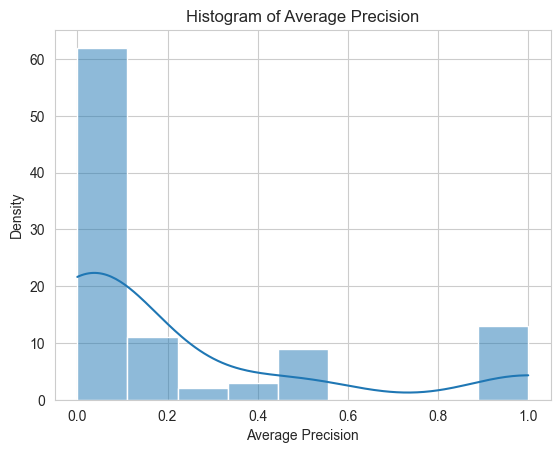

In [100]:
map_gpt4omini, map25_gpt4omini = test_batch('gpt-4o-mini', 'llm_output/gpt-4o-mini.txt')
print(f"gpt-4o-mini MAP@25: {map_gpt4omini}")
sns.histplot(map25_gpt4omini, kde=True)
plt.title('Histogram of Average Precision')
plt.xlabel('Average Precision')
plt.ylabel('Density')
plt.show()

### o1-mini
$0.12

In [95]:
map_o1mini, map25_o1mini = test_batch('o1-mini', 'llm_output/o1mini.txt')
print(f"o1-mini MAP@25: {map_o1mini}")
sns.histplot(map25_o1mini, kde=True)
plt.title('Histogram of Average Precision')
plt.xlabel('Average Precision')
plt.ylabel('Density')
plt.show()

100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


In [82]:
print(f"o1-mini MAP@25: {np.mean(map25_o1mini)}")

o1-preview MAP@25: 0.20714058529190107


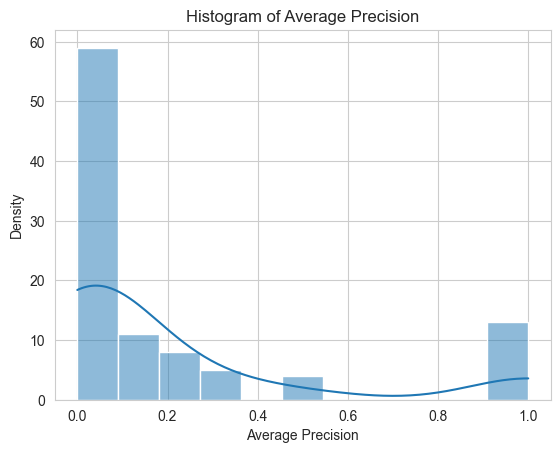

In [83]:
sns.histplot(map25_o1mini, kde=True)
plt.title('Histogram of Average Precision')
plt.xlabel('Average Precision')
plt.ylabel('Density')
plt.show()



### gpt-4o
$0.06

In [96]:
map_gpt4o, map25_gpt4o = test_batch('gpt-4o', 'llm_output/gpt-4o.txt')
print(f"gpt-4o MAP@25: {map_gpt4o}")
sns.histplot(map25_gpt4o, kde=True)
plt.title('Histogram of Average Precision')
plt.xlabel('Average Precision')
plt.ylabel('Density')
plt.show()

100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


In [97]:
print(f"gpt-4o MAP@25: {np.mean(map25_gpt4o)}")

gpt-4o MAP@25: 0.23180960150960148


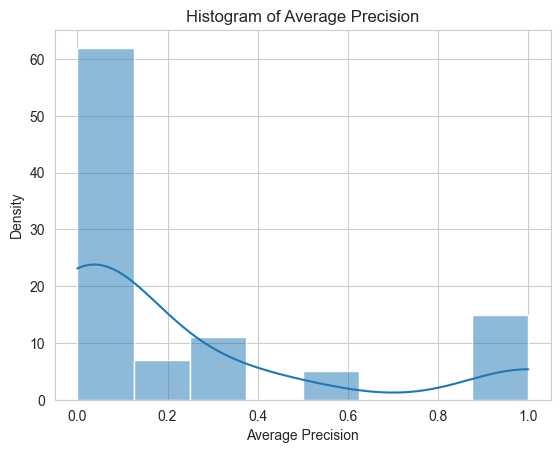

In [98]:
sns.histplot(map25_gpt4o, kde=True)
plt.title('Histogram of Average Precision')
plt.xlabel('Average Precision')
plt.ylabel('Density')
plt.show()

# Results

In [ ]:
map25_gpt4o = 0.23180960150960148
map25_gpt4omini = 0.2053288438170017
map25_o1mini = 0.20714058529190107